In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gradio
import gradio as gr
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.calibration import calibration_curve


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./SRSavg.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SRS_RAW_TOTAL      2050 non-null   int64  
 1   SRS_AWARENESS      2050 non-null   float64
 2   SRS_COGNITION      2050 non-null   float64
 3   SRS_COMMUNICATION  2050 non-null   float64
 4   SRS_MOTIVATION     2050 non-null   float64
 5   SRS_MANNERISMS     2050 non-null   float64
 6   HAS ADHD           2050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 112.2 KB


In [4]:
feature_columns = ['SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS']
target_column = 'HAS ADHD'

X = df[feature_columns]
y = df[target_column]

df.head()

,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,HAS ADHD
0,38,3.0,7.0,15.0,6.0,7.0,0
1,35,8.0,6.0,15.0,4.0,2.0,0
2,32,5.0,7.0,9.0,3.0,8.0,0
3,68,10.0,15.0,22.0,15.0,6.0,0
4,54,6.0,11.0,15.0,8.0,14.0,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,  # Number of trees
    depth=6,  # Tree depth
    learning_rate=0.1,  # Controls step size
    loss_function='Logloss',  # For binary classification
    eval_metric='Accuracy',
    verbose=100
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


0:	learn: 0.8250000	test: 0.8463415	best: 0.8463415 (0)	total: 169ms	remaining: 1m 24s
100:	learn: 0.9615854	test: 0.9243902	best: 0.9243902 (96)	total: 300ms	remaining: 1.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9390243902
bestIteration = 148

Shrink model to first 149 iterations.
Test Accuracy: 0.9390
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       205
           1       0.91      0.98      0.94       205

    accuracy                           0.94       410
   macro avg       0.94      0.94      0.94       410
weighted avg       0.94      0.94      0.94       410



In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Test Accuracy: 0.9341


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Define a larger search space for hyperparameters
param_grid = {
    'C': [1, 10,100],  # More values for regularization
    'gamma': [1, 0.1, 0.01],  # Wider range for RBF gamma
    'kernel': ['rbf'],  # Keeping the best performing kernel
}

# Initialize SVC
svm_model = SVC(probability=True)

# Using RandomizedSearchCV for better hyperparameter tuning
'''random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_grid,
    n_iter=20, cv=10, verbose=2, random_state=42, n_jobs=-1
)'''
random_search = GridSearchCV(
    svm_model, param_grid,
    cv=5, verbose=2, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best Parameters
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}")

report = classification_report(y_test, y_pred)
print(report)

def predict_data(info):
    print(best_model.predict(info))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 98.78
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       205
           1       0.99      0.99      0.99       205

    accuracy                           0.99       410
   macro avg       0.99      0.99      0.99       410
weighted avg       0.99      0.99      0.99       410



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest Performance:")
print(classification_report(y_test, rf_preds))
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.4f}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       205
           1       0.91      0.99      0.95       205

    accuracy                           0.95       410
   macro avg       0.95      0.95      0.95       410
weighted avg       0.95      0.95      0.95       410

Accuracy: 0.9488


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
log_reg_preds = log_reg_model.predict(X_test)

print("Logistic Regression Performance:")
print(classification_report(y_test, log_reg_preds))
print(f"Accuracy: {accuracy_score(y_test, log_reg_preds):.4f}")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       205
           1       0.82      0.80      0.81       205

    accuracy                           0.81       410
   macro avg       0.81      0.81      0.81       410
weighted avg       0.81      0.81      0.81       410

Accuracy: 0.8098


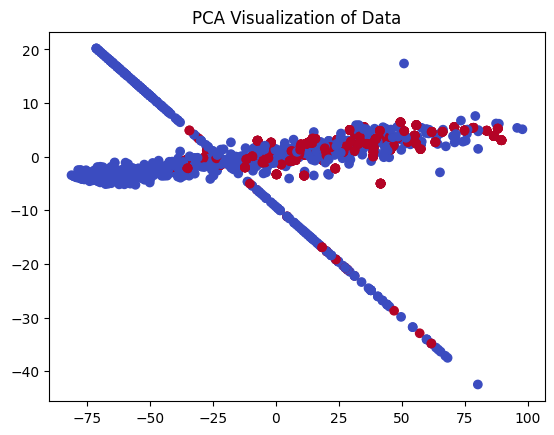

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
plt.title("PCA Visualization of Data")
plt.show()


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Define MLP Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer (Binary Classification)
])




# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7179 - loss: 0.5372 - val_accuracy: 0.5000 - val_loss: 6.8720
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8345 - loss: 0.3932 - val_accuracy: 0.5683 - val_loss: 2.0858
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8325 - loss: 0.3879 - val_accuracy: 0.5659 - val_loss: 2.5606
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8197 - loss: 0.4051 - val_accuracy: 0.5683 - val_loss: 2.8847
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.3657 - val_accuracy: 0.5683 - val_loss: 2.3653
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8374 - loss: 0.3794 - val_accuracy: 0.5780 - val_loss: 2.3419
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.3941 - val_accuracy: 0.5732 - val_loss: 2.6225
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.3586 - val_accuracy: 0.5610 - val_

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define an improved MLP model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=16, verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Improved Test Accuracy: {test_acc:.4f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 - 3s - 27ms/step - accuracy: 0.8012 - loss: 0.4484 - val_accuracy: 0.8439 - val_loss: 0.4073
Epoch 2/100
103/103 - 1s - 10ms/step - accuracy: 0.8317 - loss: 0.4011 - val_accuracy: 0.8415 - val_loss: 0.3873
Epoch 3/100
103/103 - 1s - 9ms/step - accuracy: 0.8360 - loss: 0.3957 - val_accuracy: 0.8585 - val_loss: 0.3872
Epoch 4/100
103/103 - 1s - 7ms/step - accuracy: 0.8360 - loss: 0.3862 - val_accuracy: 0.8512 - val_loss: 0.3726
Epoch 5/100
103/103 - 0s - 4ms/step - accuracy: 0.8390 - loss: 0.3782 - val_accuracy: 0.8488 - val_loss: 0.3596
Epoch 6/100
103/103 - 0s - 4ms/step - accuracy: 0.8445 - loss: 0.3683 - val_accuracy: 0.8780 - val_loss: 0.3447
Epoch 7/100
103/103 - 1s - 11ms/step - accuracy: 0.8463 - loss: 0.3581 - val_accuracy: 0.8707 - val_loss: 0.3498
Epoch 8/100
103/103 - 1s - 7ms/step - accuracy: 0.8494 - loss: 0.3564 - val_accuracy: 0.8780 - val_loss: 0.3430
Epoch 9/100
103/103 - 1s - 7ms/step - accuracy: 0.8500 - loss: 0.3558 - val_accuracy: 0.8732 - val_loss: 0.3313
E